In [1]:
import numpy as np
from scipy.optimize import curve_fit
import ROOT

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/06


In [2]:
# read in file
import os
file_name = f"{os.environ.get('HEP')}/data/ES_gvkm/ES_gvkm_radiological_0201.root"
# file_name = f"{os.environ.get('HEP')}/data/marley_gvkm_clean_0114.root"
file = ROOT.TFile(file_name)
tree=file.PointResTree.tr

In [3]:
# loop through file
# define linear coefficients for energy reconstruction
def charge_to_energy_clean(charge):
    m = 248.111
    b = 2161.06
    return (charge - b)/m
cosAngle_list = []
sample_size_per_bin = []
nbin_en = 7
e_max = 70
nbin_cosangle = 20
pdf = np.zeros([nbin_en, nbin_cosangle])
for e in tqdm(tree, total=tree.GetEntries()):
    if e.NTrks==0: continue
    en = charge_to_energy_clean(e.charge_corrected)
    if en > e_max: continue
    cosAngle = e.truth_nu_dir.Dot(e.reco_e_dir)
    en_binidx = int(en//(e_max/nbin_en)) if en > 0 else 0
    cosangle_binidx = int((cosAngle+1)//(2/nbin_cosangle))
    pdf[en_binidx, cosangle_binidx]+=1
# normalize pdf for each energy bin
for i in range(len(pdf)):
    energy_slice = pdf[i]
    sample_size_per_bin.append(np.sum(pdf[i]))
    pdf[i] = pdf[i] / np.sum(pdf[i])
# np.savetxt('ES_gvkm_radiological.dat', pdf)

100%|██████████████████████████████████████████████████████████████████████| 1148750/1148750 [00:17<00:00, 67571.32it/s]


Text(0, 0.5, '$e^-$ energy (MeV)')

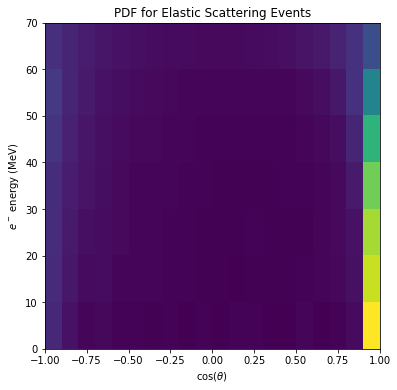

In [4]:
fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(pdf, extent=[-1,1,0,e_max], aspect='auto')
ax.set_title("PDF for Elastic Scattering Events")
ax.set_xlabel(r'$\cos(\theta)$')
ax.set_ylabel(r'$e^-$ energy (MeV)')

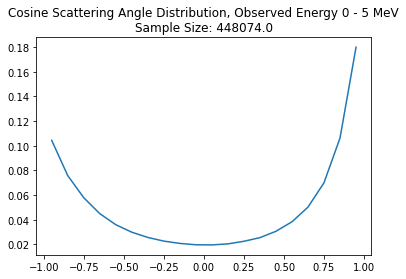

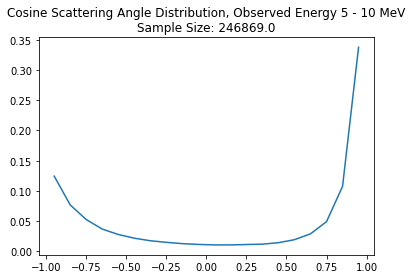

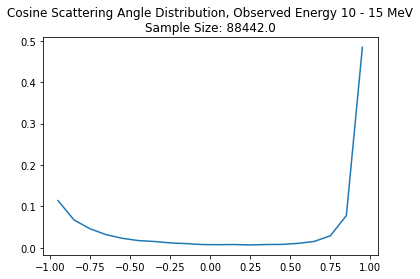

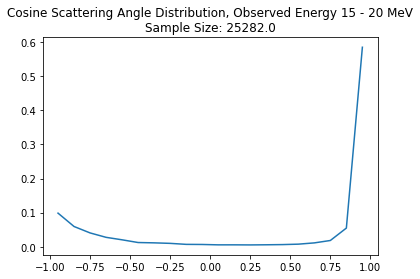

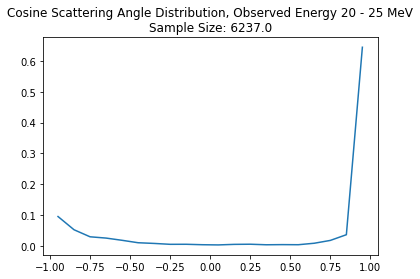

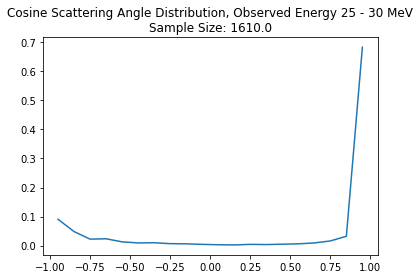

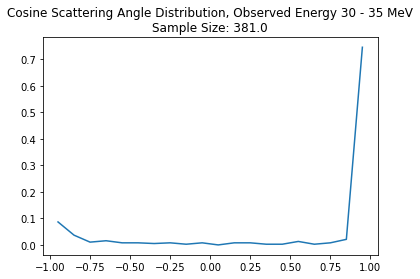

In [5]:
# energy slices
cosAngle_bins = np.linspace(-1, 1, num=20, endpoint=False) + 2/20/2
# print(cosAngle_bins)
for i, (pdf_slice, sample_size) in enumerate(zip(pdf, sample_size_per_bin)):
    plt.figure()
    plt.title(f"Cosine Scattering Angle Distribution, Observed Energy {i*5} - {(i+1)*5} MeV\n"\
            f"Sample Size: {sample_size}")
    plt.plot(cosAngle_bins, pdf_slice)

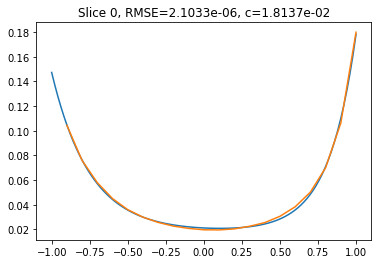

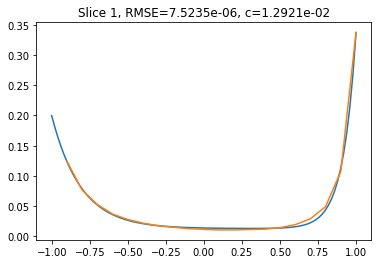

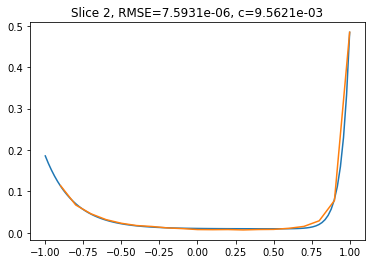

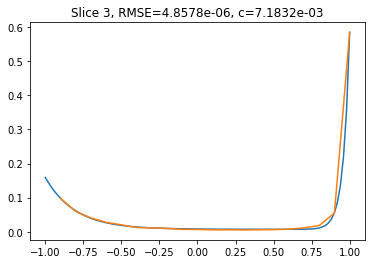

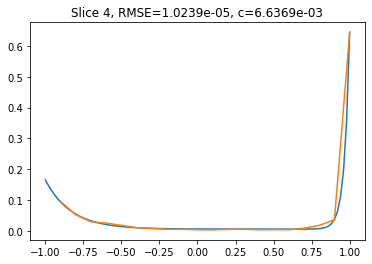

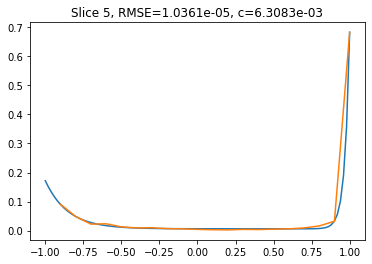

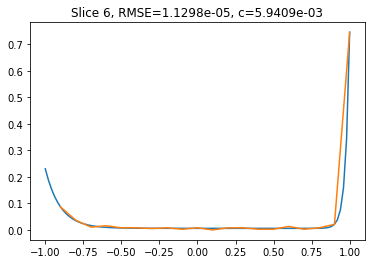

In [37]:
def bi_peak_distribution(x, g1, g2, sigma_1, sigma_2, c):
    return g1 * np.exp(- (x+1)/sigma_1) + g2 * np.exp((x-1)/sigma_2)+c
    # return g1 * np.exp(-((x+1)/sigma_1)**2) + g2 * np.exp(-((x-1)/sigma_2)**2)


linspace = np.linspace(-1, 1, 100)
bin_right_edge = cosAngle_bins + 2/20/2
for i, pdf_slice in enumerate(pdf):
    plt.figure()
    params, cov = curve_fit(bi_peak_distribution, bin_right_edge, pdf_slice, 
                            np.array([1, 1, 1, 1, 0], dtype=np.float128), 
                            bounds=(np.array([0, 0, 0, 0, 0], dtype=np.float128), 
                                    np.array([np.inf, np.inf, np.inf, np.inf, 0.1], dtype=np.float128)))
    rmse = np.mean((pdf_slice - bi_peak_distribution(bin_right_edge, *params))**2)
    plt.plot(linspace, bi_peak_distribution(linspace, *params))
    plt.plot(bin_right_edge, pdf_slice)
    plt.title(f"Slice {i}, RMSE={rmse:.4e}, c={params[-1]:.4e}")
# plt.plot(x, bi_peak_distribution(x, 0.13, 0.4, 5, 10))

In [7]:
# #res = curve_fit(bi_peak_distribution, cosAngle_bins, slice_fit, [0.1, 0.4, 5, 10], bounds=([0.01, 0.01, 0.5, 0.5], [1, 1, 20, 20]), method='dogbox')
# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c


# xdata = np.linspace(0, 4, 50)
# y = func(xdata, 2.5, 1.3, 0.5)

# #rng = np.random.default_rng()

# #y_noise = 0.2 * rng.normal(size=xdata.size)

# ydata = y
# res = curve_fit(func, xdata, ydata)
# print(res)

In [8]:
!pip list --outdated

Package  Version Latest Type
-------- ------- ------ -----
docutils 0.17.1  0.18.1 wheel
mistune  0.8.4   2.0.2  wheel
